# Evaluation


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = [10, 5]

# Continual Learning Metrics

In [2]:
# Because of a mistake in my implementation
# ["no_of_test"] cannot be used but it can be calculated by ["no_of_correct_prediction"]/["accuracy"]
# but it cannot be calculated when ["accuracy"] == 0

# ((raw["no_of_correct_prediction"]/ raw["accuracy"]).apply(np.ceil))

# the mistake have been fixed now but the data have not updated

def calculateContinualMetircs(raw):
    task_order = raw["task_order"].unique()
    method = raw["method"].unique()
    print(task_order, method)
    
    all_MBase = {k:[] for k in method}
    all_Mnew  = {k:[] for k in method}
    all_Mnow  = {k:[] for k in method}

    for t in task_order:
        rows = raw[raw["task_order"]==t]
        offline = rows[rows["method"]=="offline"]


        for m in method:
            if m=="offline":
                continue

            target = rows[rows["method"]==m]

            # calculate m_base
            _ideal = offline[offline["task_index"]==1]["accuracy"]
            _m = target[target["task_index"]==1][["accuracy", "no_of_test", "no_of_correct_prediction"]]

            _N = len(_m)
            _m = (_m["accuracy"]/float(_ideal)).sum()
            Mbase = float(_m/_N)

            all_MBase[m].append(Mbase)


            _sum = 0.0
            train_session = target["train_session"].unique()
            for s in train_session:
                s = int(s)
                _ideal = offline[offline["task_index"]==s]["accuracy"]

                _m = target[target["train_session"]==str(s)]
                _m = _m[_m["task_index"]==s]["accuracy"]

                assert len(_m)==1

                _sum += float(_m)/float(_ideal)

            if len(train_session)==0:
                all_Mnew[m].append(np.nan)
            else:
                Mnew = _sum/len(train_session)
                all_Mnew[m].append(Mnew)


            _sum = 0.0
            task_index = target["task_index"].unique()
            _m = target[target["train_session"]==str(len(task_index))]
            for t in task_index:
                t = int(t)
                _ideal = offline[offline["task_index"]==t]["accuracy"]
                _m1 = _m[_m["task_index"]==t]["accuracy"]

                assert len(_m1)==1

                _sum += float(_m1)/float(_ideal)

            if len(train_session)==0:
                all_Mnow[m].append(np.nan)
            else:
                Mnow = _sum/len(train_session)
                all_Mnow[m].append(Mnow)

            
    return all_MBase, all_Mnew, all_Mnow



In [3]:
from scipy import stats

def printCLMetrics(all_MBase, all_Mnew, all_Mnow):
    def p(metric, name):
        
        print("Metric: ", name)
        for m in metric:
            avg = np.mean(metric[m])
            err = stats.sem(metric[m])
            print("{0} {1:.3f} {2:.3f}".format(m, avg, err))
        print("=====================")
        print("")
            
            
    p(all_MBase, "M base")
    p(all_Mnew, "M new")
    p(all_Mnow, "M now")
    
    

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

def plot(values, label, width=0.85, offset_ratio=0.375, xticks=[], models=None, rotation=0, show_legend=True):
    
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.rcParams.update({'font.size': 20})
    m = [] 
    merr = []
    if models is None:
        models = ["mp-gan", "mp-wgan", "sg-cgan", "sg-cwgan"]
        
    for model in models:
        
        tmp = []
        tmperr = []
        for i, v in enumerate(values):
            avg = np.mean(v[model])
            err = stats.sem(v[model])
            tmp.append(avg)
            tmperr.append(err)
        
        m.append(tmp)
        merr.append(tmperr)

    ind = np.arange(len(m[0])) # the x locations for the groups

    fig, ax = plt.subplots()
    
    patterns = [ "/" , "\\" , "x" , "-" , "+" , "|", "o", "O", ".", "*" ]
    for i, model in enumerate(models):
        offset = (float(i)/len(models))*width
        offset -= (offset_ratio)*width
        ax.bar(ind + offset, m[i], width*(1.0/len(models)), yerr=merr[i], label=model, hatch=patterns[i])

    ax.set_title(label)
    ax.set_xticks(ind)
    ax.set_xticklabels(xticks, rotation=rotation)
    if show_legend:
        ax.legend(prop={'size': 20}, bbox_to_anchor=(1.05, 1), loc=0, borderaxespad=0.)


    fig.tight_layout()

    plt.show()




# Output function

In [5]:
# # This result is not complete

# CSMbase = []
# CSMnew = []
# CSMnow = []

# folder = "../Results/results_output_unit/"

# raw = pd.read_csv(folder+"results.txt")
# raw.columns = [c.strip() for c in raw.columns]
# raw.head()

# cmd = raw["cmd"].unique()

# for c in cmd:
#     target = raw[raw["cmd"]==c]
#     b, n, nw = calculateContinualMetircs(target)

#     CSMbase.append(b)
#     CSMnew.append(n)
#     CSMnow.append(nw)
    
# xticks = ["none", "leaky_relu", "sigmoid"]

# models = None
# def fixbugs(data):
#     return data

# plot(fixbugs(CSMbase), "Stability of the model in different output unit", xticks=xticks, models=models)
# plot(fixbugs(CSMnew), "Plasticity of the model in different output unit", xticks=xticks, models=models)
# plot(fixbugs(CSMnow),"Overall performance of the model in different output unit", xticks=xticks, models=models)

# Number of hidden units per layer 👌


In [6]:


import matplotlib
import matplotlib.pyplot as plt
import numpy as np

def plotline(values, label, x=[], xticks=[], models=None):
    
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.rcParams.update({'font.size': 20})
    
    m = [] 
    merr = []
    if models is None:
        models = ["mp-gan", "mp-wgan", "sg-cgan", "sg-cwgan"]
    print(models)
    for model in models:
        
        tmp = []
        tmperr = []
        
        for i, v in enumerate(values):
            if model not in v:
                v[m]
            avg = np.nanmean(v[model])
            err = stats.sem(v[model], nan_policy="omit")
            tmp.append(avg)
            tmperr.append(err)
        
        m.append(tmp)
        merr.append(tmperr)

    ind = np.arange(len(m[0])) # the x locations for the groups

    fig, ax = plt.subplots()
    
    patterns = [ "-s" , "-o" , "-x" , "-D" , "-+" , "-*", "-2" ]
    for i, model in enumerate(models):
        ax.errorbar(x, m[i], yerr=merr[i], fmt=patterns[i])

    ax.set_title(label)
    ax.set_xticks(x)
    ax.set_xticklabels(x)
    ax.legend(models, prop={'size': 20}, loc=2)
#     ax.legend(prop={'size': 20}, bbox_to_anchor=(1.05, 1), loc=0, borderaxespad=0.)


    fig.tight_layout()

    plt.show()





[0 1 2 3 4 5 6 7 8 9] ['offline' 'none' 'exact' 'mp-gan' 'mp-wgan' 'sg-cgan' 'sg-cwgan' 'lwf'
 'ewc']
[0 1 2 3 4 5 6 7 8 9] ['offline' 'none' 'exact' 'mp-gan' 'mp-wgan' 'sg-cgan' 'sg-cwgan' 'lwf'
 'ewc']
[0 1 2 3 4 5 6 7 8 9] ['offline' 'none' 'exact' 'mp-gan' 'mp-wgan' 'sg-cgan' 'sg-cwgan' 'lwf'
 'ewc']
[0 1 2 3 4 5 6 7 8 9] ['offline' 'none' 'exact' 'mp-gan' 'mp-wgan' 'sg-cgan' 'sg-cwgan' 'lwf'
 'ewc']
[{'offline': [], 'none': [0.27932489451476794, 0.22371794871794873, 0.23492063492063492, 0.20414507772020726, 0.25934065934065936, 0.30604982206405695, 0.24, 0.2041666666666667, 0.3388888888888889, 0.4009615384615384], 'exact': [1.0345991561181436, 1.1102564102564103, 1.0222222222222224, 1.0031088082901554, 1.0725274725274725, 1.0412811387900356, 1.1458823529411764, 1.0027777777777778, 1.5766666666666667, 1.15], 'mp-gan': [0.7502109704641351, 0.45961538461538465, 0.6412698412698413, 0.46943005181347147, 0.5483516483516484, 0.4313167259786477, 0.4258823529411765, 0.6680555555555556, 0.9

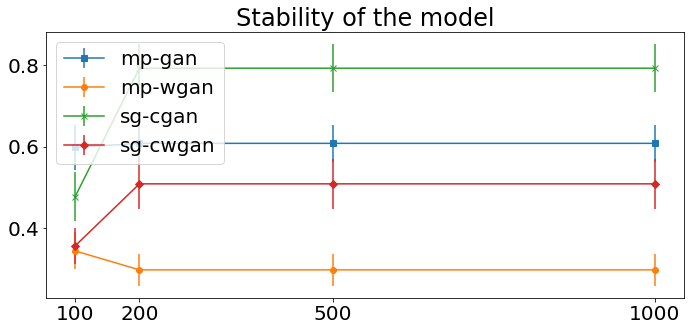

['mp-gan', 'mp-wgan', 'sg-cgan', 'sg-cwgan']


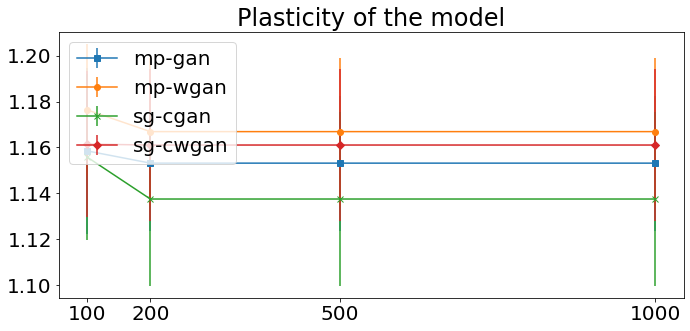

['mp-gan', 'mp-wgan', 'sg-cgan', 'sg-cwgan']


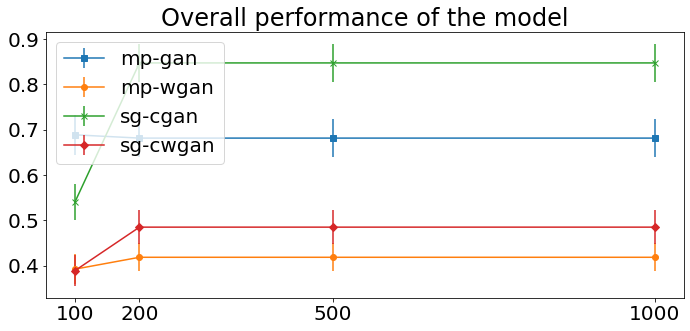

In [9]:
CSMbase = []
CSMnew = []
CSMnow = []

folder = "../Results/PAMAP/exp_no_of_hidden/"

raw = pd.read_csv(folder+"results.txt")
raw.columns = [c.strip() for c in raw.columns]
raw.head()


cmd = raw["cmd"].unique()
for c in cmd:
    target = raw[raw["cmd"]==c]
    b, n, nw = calculateContinualMetircs(target)

    CSMbase.append(b)
    CSMnew.append(n)
    CSMnow.append(nw)
    
xticks = [100, 200, 500, 1000]

models = None
def fixbugs(data):
    return data

models = ["mp-gan", "mp-wgan", "sg-cgan", "sg-cwgan"]
print(CSMbase)
plotline(fixbugs(CSMbase), "Stability of the model", x=xticks, models=models)
plotline(fixbugs(CSMnew), "Plasticity of the model", x=xticks, models=models)
plotline(fixbugs(CSMnow),"Overall performance of the model", x=xticks, models=models)

# Generator Training Iterators 👌

[0 1 2 3 4 5 6 7 8 9] ['offline' 'none' 'exact' 'mp-gan' 'mp-wgan' 'sg-cgan' 'sg-cwgan']
[0 1 2 3 4 5 6 7 8 9] ['offline' 'none' 'exact' 'mp-gan' 'mp-wgan' 'sg-cgan' 'sg-cwgan']
[0 1 2 3 4 5 6 7 8 9] ['offline' 'none' 'exact' 'mp-gan' 'mp-wgan' 'sg-cgan' 'sg-cwgan']
[0 1 2 3 4 5 6 7 8 9] ['offline' 'none' 'exact' 'mp-gan' 'mp-wgan' 'sg-cgan' 'sg-cwgan']
['mp-gan', 'mp-wgan', 'sg-cgan', 'sg-cwgan']


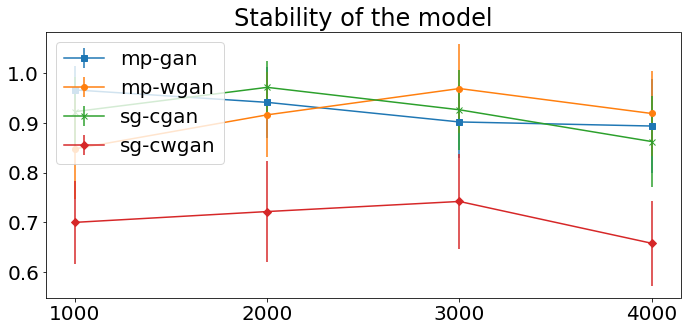

['mp-gan', 'mp-wgan', 'sg-cgan', 'sg-cwgan']


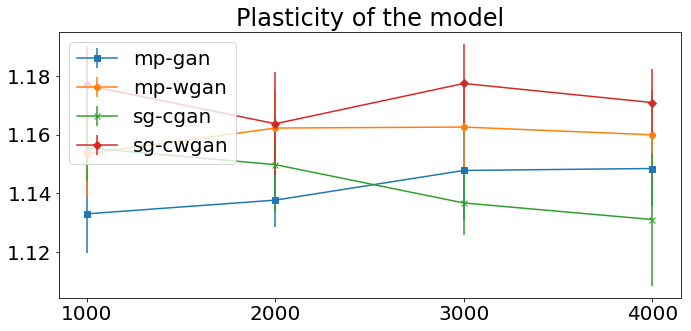

['mp-gan', 'mp-wgan', 'sg-cgan', 'sg-cwgan']


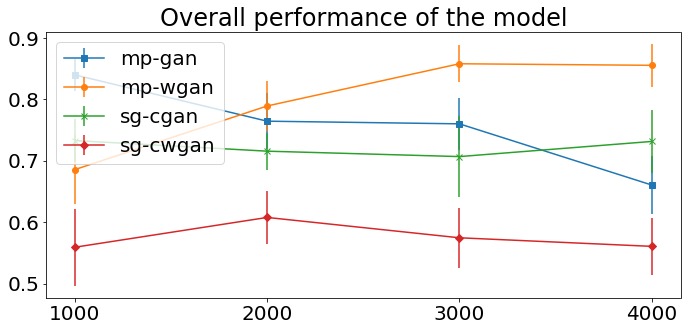

In [12]:
CSMbase = []
CSMnew = []
CSMnow = []

folder = "../Results/run_house_iter/"

raw = pd.read_csv(folder+"results.txt")
raw.columns = [c.strip() for c in raw.columns]
raw.head()


cmd = raw["cmd"].unique()
for c in cmd:
    target = raw[raw["cmd"]==c]
    b, n, nw = calculateContinualMetircs(target)

    CSMbase.append(b)
    CSMnew.append(n)
    CSMnow.append(nw)
    
xticks = (1000, 2000, 3000, 4000)
plotline(CSMbase, "Stability of the model", x=xticks)
plotline(CSMnew, "Plasticity of the model", x=xticks)
plotline(CSMnow, "Overall performance of the model", x=xticks)

# Sample important 👌

[0 1 2 3 4 5 6 7 8 9] ['offline' 'mp-gan' 'sg-cgan']
[0 1 2 3 4 5 6 7 8 9] ['offline' 'mp-gan' 'sg-cgan']
[0 1 2 3 4 5 6 7 8 9] ['offline' 'mp-gan' 'sg-cgan']
[0 1 2 3 4 5 6 7 8 9] ['offline' 'none' 'exact' 'mp-gan' 'mp-wgan' 'sg-cgan' 'sg-cwgan']
[0 1 2 3 4 5 6 7 8 9] ['offline' 'mp-gan' 'sg-cgan']
[0 1 2 3 4 5 6 7 8 9] ['offline' 'mp-gan' 'sg-cgan']


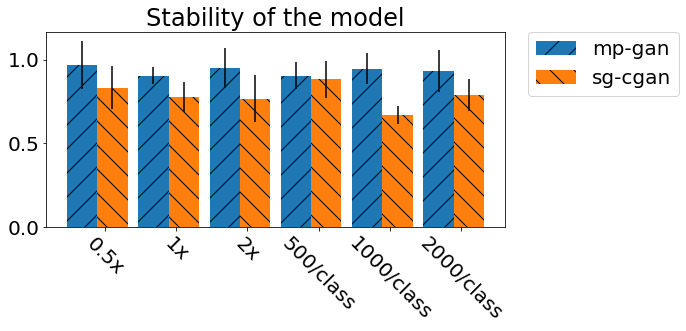

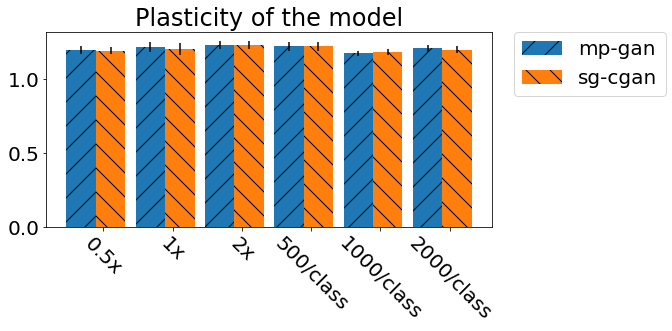

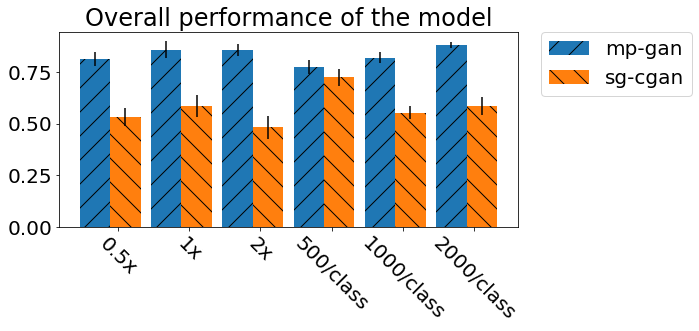

In [57]:
CSMbase = []
CSMnew = []
CSMnow = []

folder = "../Results/results_sample_important/"

raw = pd.read_csv(folder+"results.txt")
raw.columns = [c.strip() for c in raw.columns]
raw.head()


cmd = raw["cmd"].unique()
cmd = [1, 3, 4]
for c in cmd:
    target = raw[raw["cmd"]==c]
    b, n, nw = calculateContinualMetircs(target)

    CSMbase.append(b)
    CSMnew.append(n)
    CSMnow.append(nw)

raw = pd.read_csv("../Results/result_iter5000-1000_h500-100_all/"+"results.txt")
raw.columns = [c.strip() for c in raw.columns]
b, n, nw = calculateContinualMetircs(raw)
CSMbase.append(b)
CSMnew.append(n)
CSMnow.append(nw)

folder = "../Results/results_sample_important.v2/"

raw = pd.read_csv(folder+"results.txt")
raw.columns = [c.strip() for c in raw.columns]
raw.head()


cmd = raw["cmd"].unique()
for c in cmd:
    target = raw[raw["cmd"]==c]
    b, n, nw = calculateContinualMetircs(target)

    CSMbase.append(b)
    CSMnew.append(n)
    CSMnow.append(nw)
    

xticks = ["0.5x", "1x", "2x", "500/class", "1000/class", "2000/class"]

models = ["mp-gan", "sg-cgan"]
plot((CSMbase), "Stability of the model", xticks=xticks, models=models, rotation=-45)
plot((CSMnew), "Plasticity of the model", xticks=xticks, models=models, rotation=-45)
plot((CSMnow),"Overall performance of the model", xticks=xticks, models=models, rotation=-45)

# Component sensitivity

In [64]:
CSMbase = []
CSMnew = []
CSMnow = []

# folder = "../Results/result_component_sensitivity.v1/results/"
folder = "../Results/result_comp_sense/"
# folder = "./newsrc/result_comp_sense-draft/"

raw = pd.read_csv(folder+"results.txt")
raw.columns = [c.strip() for c in raw.columns]
raw.head()


cmd = raw["cmd"].unique()
cmd = [0, 1, 2, 3, 4, 5, 11]
for c in cmd:
    target = raw[raw["cmd"]==c]
    b, n, nw = calculateContinualMetircs(target)

    CSMbase.append(b)
    CSMnew.append(n)
    CSMnow.append(nw)

xticks = [
    "no additional\n components", 
    "self-verifying", 
    "oversampling", 
    "EWC\n in solver", 
    "knowledge distill \n in solver", 
    "instance noise\n in GANs", 
    "final"]

# models = None
# plot((CSMbase), "Stability of the model", xticks=xticks, models=models)
# plot((CSMnew), "Plasticity of the model", xticks=xticks, models=models)
# plot((CSMnow),"Overall performance of the model", xticks=xticks, models=models)

[0 1 2 3 4 5 6 7 8 9] ['offline' 'mp-gan']
[0 1 2 3 4 5 6 7 8 9] ['offline' 'mp-gan']
[0 1 2 3 4 5 6 7 8 9] ['offline' 'mp-gan']
[0 1 2 3 4 5 6 7 8 9] ['offline' 'mp-gan']
[0 1 2 3 4 5 6 7 8 9] ['offline' 'mp-gan']
[0 1 2 3 4 5 6 7 8 9] ['offline' 'mp-gan']
[0 1 2 3] ['offline' 'mp-gan']


[[1.232216996194599, 1.095174566303729, 0.8025242897863489, 0.7681895196630892, 1.163908768176618, 1.1949028822086751, 0.9873093968112602]]


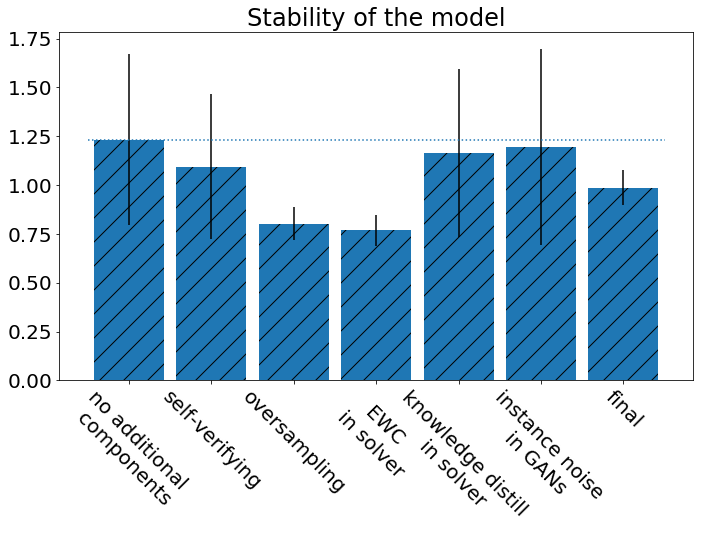

In [96]:
def plot2(values, label, width=0.85, offset_ratio=0, xticks=[], models=None, rotation=0):
    
    plt.rcParams['figure.figsize'] = [10, 8]
    
    m = [] 
    merr = []
    if models is None:
        models = ["mp-gan", "mp-wgan", "sg-cgan", "sg-cwgan"]
        
    for model in models:
        
        tmp = []
        tmperr = []
        for i, v in enumerate(values):
            avg = np.mean(v[model])
            err = stats.sem(v[model])
            tmp.append(avg)
            tmperr.append(err)
        
        m.append(tmp)
        merr.append(tmperr)

    ind = np.arange(len(m[0])) # the x locations for the groups

    fig, ax = plt.subplots()
    
    patterns = [ "/" , "\\" , "x" , "-" , "+" , "|", "o", "O", ".", "*" ]
    for i, model in enumerate(models):
        offset = (float(i)/len(models))*width
        offset -= (offset_ratio)*width
        ax.bar(ind + offset, m[i], width*(1.0/len(models)), yerr=merr[i], label=model, hatch=patterns[i])
        
        X = np.arange(-0.5, len(m[0])+0.5)
        Y = [m[i][0] for _ in range(len(X))]
        ax.plot(X, Y, linestyle=':')

    print(m)
    ax.set_title(label)
    ax.set_xticks(ind)
    ax.set_xticklabels(xticks, rotation=rotation, rotation_mode="default")
#     ax.legend()

    fig.tight_layout()

    plt.show()
    

models = ["mp-gan"]
plot2((CSMbase), "Stability of the model", xticks=xticks, models=models, rotation=-45)

[[1.3647329483778152, 1.2040391843142433, 1.1810662513311445, 1.2035002624131488, 1.3397870458836278, 1.5870316449157964, 1.1945043440752297]]


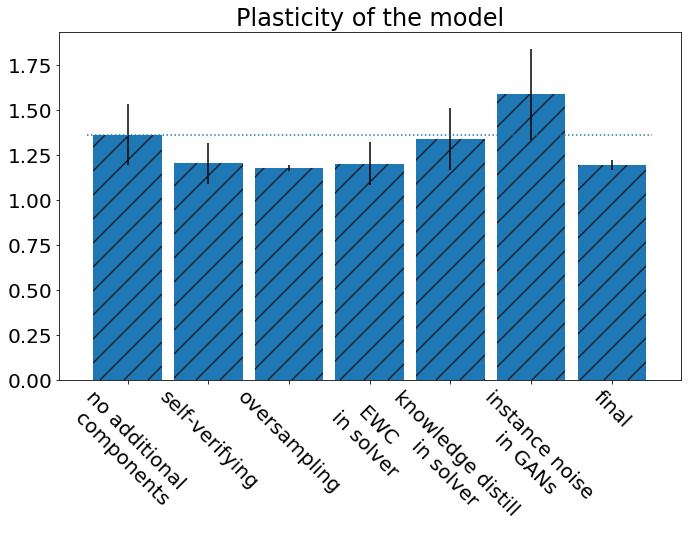

In [97]:
plot2((CSMnew), "Plasticity of the model", xticks=xticks, models=models, rotation=-45)

[[0.9734605403799025, 0.8557264070120265, 0.8640647283523938, 0.9038508955432036, 0.8794707790664564, 0.8399602979390345, 0.8408561102738352]]


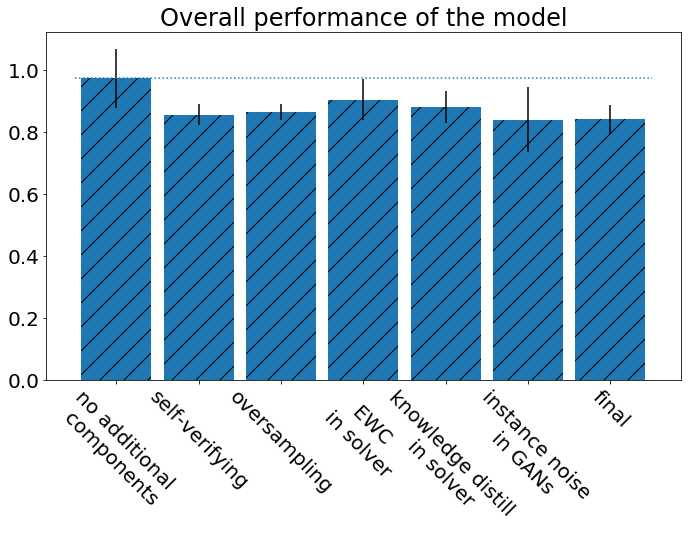

In [98]:

plot2((CSMnow),"Overall performance of the model", xticks=xticks, models=models, rotation=-45)